In [41]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
import math
from scipy.stats import f_oneway

# Import your Experiment class and related entities
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [42]:
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30

In [43]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            file_path = os.path.join(data_folder, file)
            with open(file_path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

In [44]:
def get_sapap_genotype(genotype_string):
    if "Sapap(" in genotype_string:
        start_index = genotype_string.find("Sapap(") + len("Sapap(")
        end_index = genotype_string.find(")", start_index)
        return genotype_string[start_index:end_index]
    return None

def group_experiments_by_genotype(experiments):
    group_WT, group_KO = [], []
    for exp in experiments:
        genotype = get_sapap_genotype(exp.Genotype)
        if genotype == "WT":
            group_WT.append(exp)
        elif genotype == "KO":
            group_KO.append(exp)
        else:
            print(f"Warning: Unknown or missing Sapap genotype for Mouse {exp.Mouse_id}")
    print(f"Number of WT mice: {len(group_WT)}")
    print(f"Number of KO mice: {len(group_KO)}")
    return group_WT, group_KO


Extract and average the GCaMP z-score data for each group.


Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
Number of WT mice: 5
Number of KO mice: 8


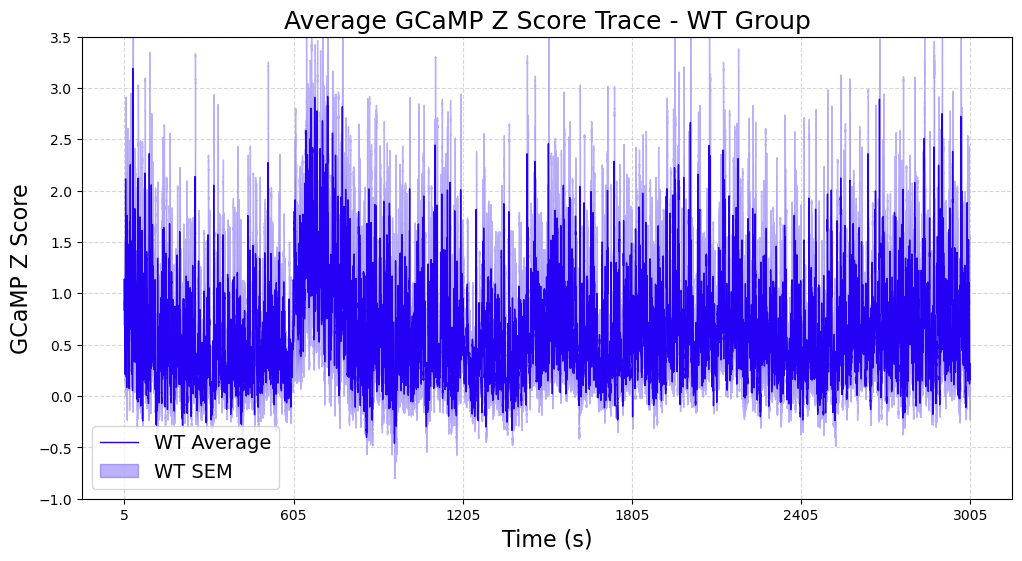

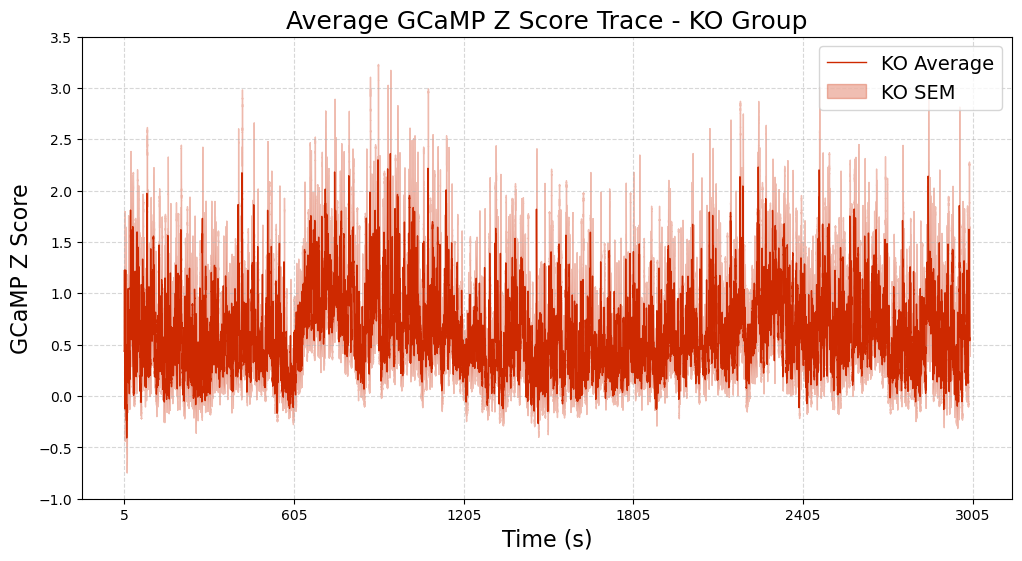

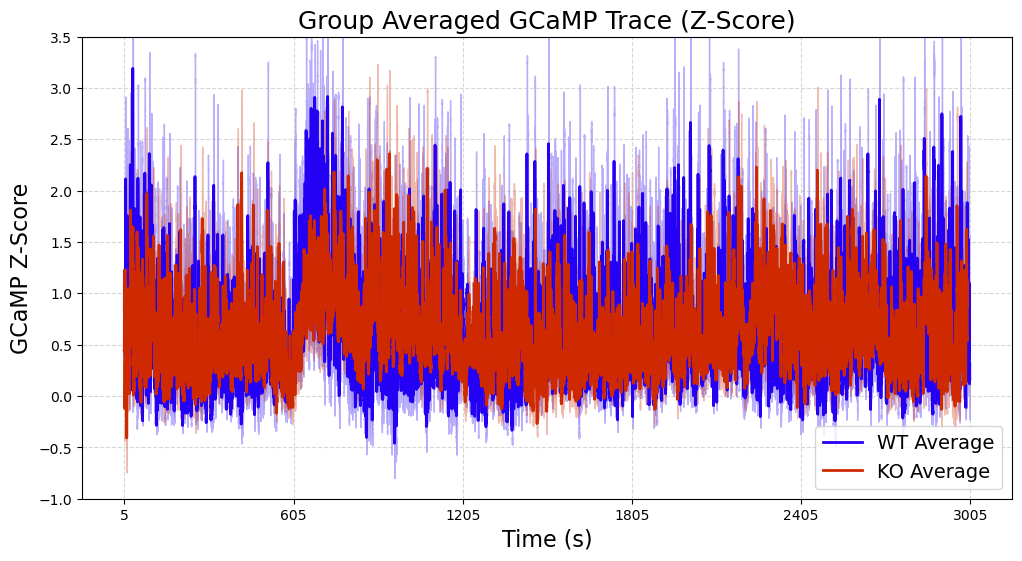

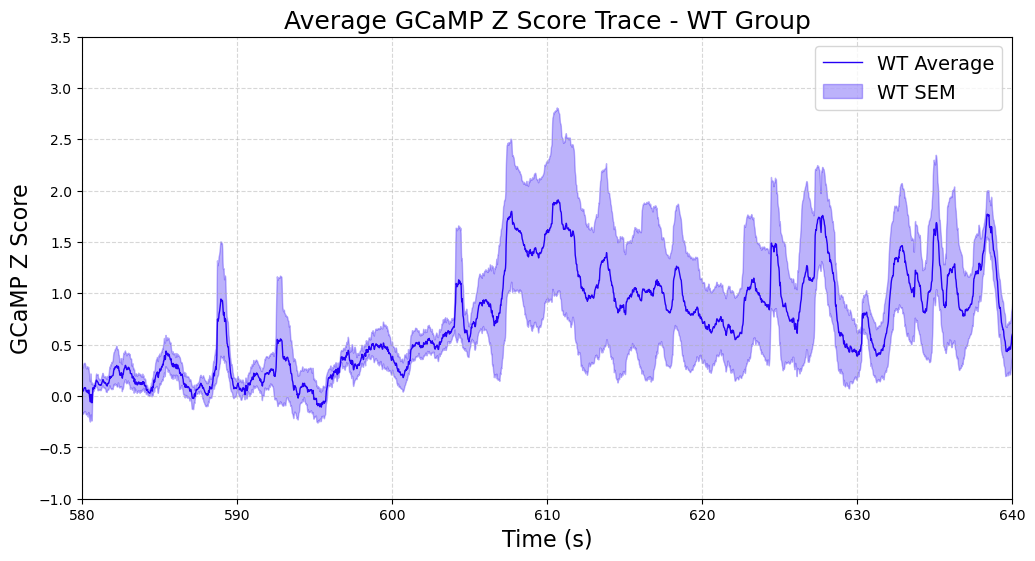

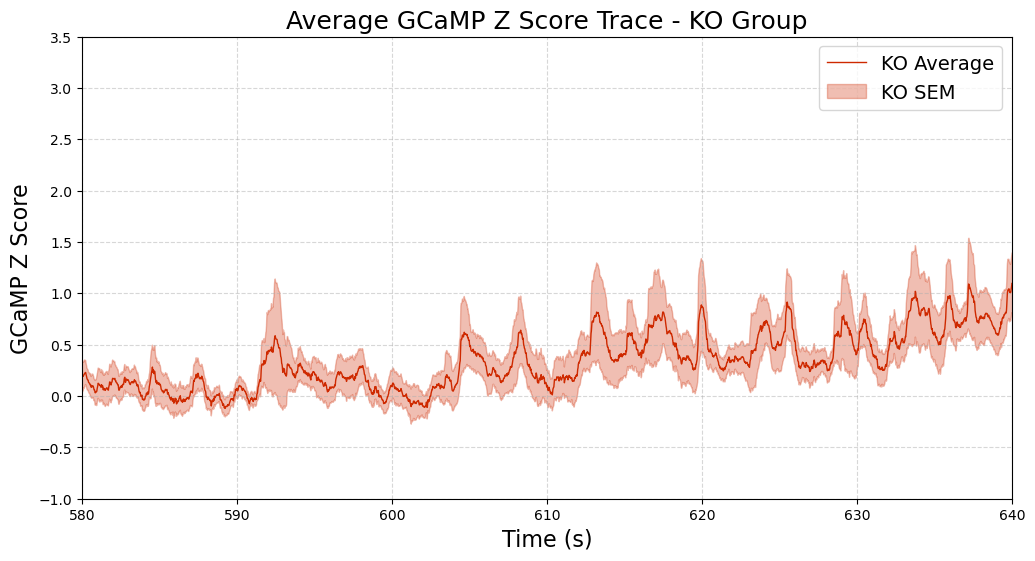

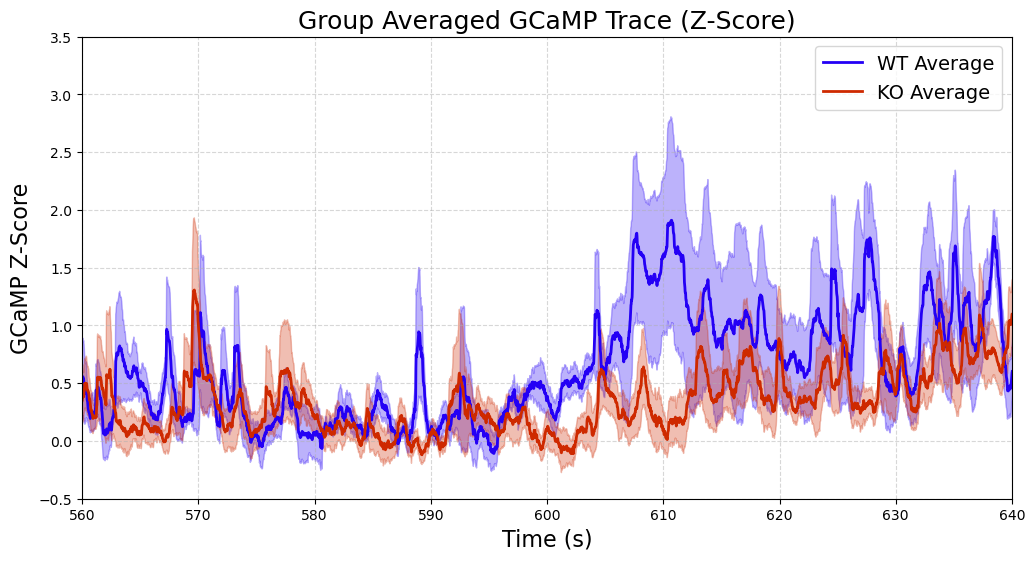

In [50]:
def extract_zscore_and_time(experiments_group):
    """
    For a group of experiments, extract each experiment's z-score and time vectors.
    Since experiments might have different lengths, create a common time vector
    (spanning the overlapping time range) and interpolate each z-score trace on it.
    Returns:
        avg_zscore : numpy array with the average z-score trace.
        std_zscore : numpy array with the standard deviation.
        sem_zscore : numpy array with the standard error of the mean (SEM).
        common_time: numpy array representing the common time vector.
    """
    zscore_list = []
    time_list = []
    
    for exp in experiments_group:
        z = exp.GCaMP_data.z_score
        t = exp.GCaMP_data.time
        zscore_list.append(z)
        time_list.append(t)
    
    # Determine the overlapping time period
    start_time = max(t[0] for t in time_list)
    end_time = min(t[-1] for t in time_list)
    
    dt = np.mean(np.diff(time_list[0]))  # Assume similar sampling for all experiments
    common_time = np.arange(start_time, end_time, dt)
    
    interp_zscores = []
    for t, z in zip(time_list, zscore_list):
        interp_z = np.interp(common_time, t, z)
        interp_zscores.append(interp_z)
    
    zscore_array = np.array(interp_zscores)
    avg_zscore = np.mean(zscore_array, axis=0)
    std_zscore = np.std(zscore_array, axis=0)
    sem_zscore = std_zscore / np.sqrt(len(zscore_array))
    return avg_zscore, std_zscore, sem_zscore, common_time


def plot_average_trace(time, avg_trace, group_label, color, sem=None, y_limits=None, y_tick_interval=None, x_limits=None, x_tick_interval=None):
    """
    Plots the average GCaMP z-score trace with the given time vector.
    
    Optional Parameters:
      - y_limits (tuple): Sets the y-axis limits as (y_min, y_max).
      - y_tick_interval (float): Sets the interval for y-axis ticks.
      - x_limits (tuple): If provided, sets the x-axis limits as (x_min, x_max), allowing you to zoom in.
      - x_tick_interval (float): If x_limits is given, defines the interval for x-axis ticks within that range.
      - sem (numpy array): If provided, plots the SEM as a shaded area around avg_trace.
    
    If x_limits is not provided, the x-axis ticks default to every 600 seconds.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time, avg_trace, color=color, linewidth=1, label=f"{group_label} Average")
    if sem is not None:
        plt.fill_between(time, avg_trace - sem, avg_trace + sem, color=color, alpha=0.3, label=f"{group_label} SEM")
    
    plt.xlabel("Time (s)", fontsize=16)
    plt.ylabel("GCaMP Z Score", fontsize=16)
    plt.title(f"Average GCaMP Z Score Trace - {group_label} Group", fontsize=18)
    
    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)
    
    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)
    else:
        xticks = np.arange(time[0], time[-1] + 600, 600)
        plt.xticks(xticks)
    
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def plot_combined_average_traces(time_wt, avg_wt, sem_wt,
                                 time_ko, avg_ko, sem_ko,
                                 y_limits=None, y_tick_interval=None,
                                 x_limits=None, x_tick_interval=None):
    """
    Plots the combined average GCaMP z-score traces for both WT and KO groups on the same axes.
    
    Optional Parameters:
      - y_limits (tuple): If provided, sets the y-axis limits as (y_min, y_max).
      - y_tick_interval (float): Sets the interval for y-axis ticks.
      - x_limits (tuple): If provided, sets the x-axis limits as (x_min, x_max).
      - x_tick_interval (float): If x_limits is given, defines the interval for x-axis ticks.
      - sem_wt, sem_ko (numpy arrays): If provided, plots the SEM as shaded areas.
      
    If y_limits is not provided, the function will auto-scale the y-axis and then re-set the ticks 
    to round numbers at the given y_tick_interval.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(time_wt, avg_wt, color='#2400f5', linewidth=2, label='WT Average')
    if sem_wt is not None:
        plt.fill_between(time_wt, avg_wt - sem_wt, avg_wt + sem_wt, color='#2400f5', alpha=0.3)
    
    plt.plot(time_ko, avg_ko, color='#ce2900', linewidth=2, label='KO Average')
    if sem_ko is not None:
        plt.fill_between(time_ko, avg_ko - sem_ko, avg_ko + sem_ko, color='#ce2900', alpha=0.3)
    
    plt.xlabel("Time (s)", fontsize=16)
    plt.ylabel("GCaMP Z-Score", fontsize=16)
    plt.title("Group Averaged GCaMP Trace (Z-Score)", fontsize=18)
    
    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)
    else:
        # Use auto-scaling, then update y-ticks to be round numbers at the given interval.
        ax = plt.gca()
        # Force a draw to update the auto-scaled limits
        plt.draw()
        auto_ylim = ax.get_ylim()
        new_ymin = math.floor(auto_ylim[0] * 2) / 2
        new_ymax = math.ceil(auto_ylim[1] * 2) / 2
        plt.ylim(new_ymin, new_ymax)
        if y_tick_interval is not None:
            yticks = np.arange(new_ymin, new_ymax + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)
    
    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)
    else:
        xticks = np.arange(time_wt[0], time_wt[-1] + 600, 600)
        plt.xticks(xticks)
    
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

if __name__ == '__main__':
    # Load experiments from disk
    experiments = load_experiments(DATA_FOLDER)
    
    # Group experiments by genotype (WT and KO)
    group_WT, group_KO = group_experiments_by_genotype(experiments)
    
    # For WT group: Extract z-score data and compute the average, std, and SEM.
    avg_zscore_wt, std_wt, sem_wt, common_time_wt = extract_zscore_and_time(group_WT)
    
    # For KO group: Extract z-score data and compute the average, std, and SEM.
    avg_zscore_ko, std_ko, sem_ko, common_time_ko = extract_zscore_and_time(group_KO)
    
    y_tick_interval = 0.5
    wt_dynamic_min = avg_zscore_wt.min() - 0.2
    wt_dynamic_max = avg_zscore_wt.max() + 0.2

    # Round down the min to the nearest 0.5 and round up the max to the nearest 0.5
    new_y_min = math.floor(wt_dynamic_min * 2) / 2
    new_y_max = math.ceil(wt_dynamic_max * 2) / 2

    dynamic_y_limits = (new_y_min, new_y_max)
 

# Plot Traces
    plot_average_trace(common_time_wt, avg_zscore_wt, group_label="WT", color='#2400f5', y_limits=dynamic_y_limits, y_tick_interval=0.5, sem=sem_wt)
                    
    plot_average_trace(common_time_ko, avg_zscore_ko, group_label="KO", color='#ce2900', y_limits=dynamic_y_limits, y_tick_interval=0.5, sem=sem_ko)

    plot_combined_average_traces(common_time_wt, avg_zscore_wt, sem_wt, common_time_ko, avg_zscore_ko, sem_ko, y_limits=dynamic_y_limits, y_tick_interval=0.5)

# Plot specific Time - Windows
    plot_average_trace(common_time_wt, avg_zscore_wt, group_label="WT", color='#2400f5', y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval,
                    x_limits=(580, 640), x_tick_interval=10, sem=sem_wt)
                    
    plot_average_trace(common_time_ko, avg_zscore_ko, group_label="KO", color='#ce2900', y_limits=dynamic_y_limits, y_tick_interval=y_tick_interval,
                    x_limits=(580, 640), x_tick_interval=10, sem=sem_ko)
                    
    plot_combined_average_traces(common_time_wt, avg_zscore_wt, sem_wt, common_time_ko, avg_zscore_ko, sem_ko,
                                y_limits=(-0.5, 3.5), y_tick_interval=0.5, x_limits=(560, 640), x_tick_interval=10)


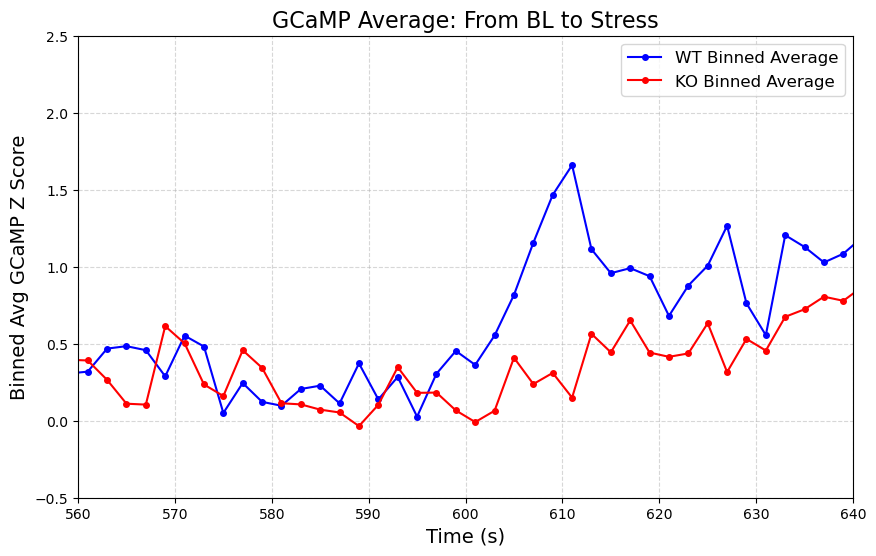

In [48]:
def bin_average_trace(time, avg_trace, bin_size=10):
    """
    Given a time vector and corresponding average trace, compute the mean z-score
    in bins of bin_size seconds. Bins are anchored at 0 (i.e. [0,bin_size), [bin_size,2*bin_size), etc.).
    
    Returns:
        bin_centers: numpy array of bin center times.
        binned_avg: numpy array of the mean z-score for each bin.
    """
    # Create bin edges starting at 0
    bins = np.arange(0, time[-1] + bin_size, bin_size)
    bin_centers = []
    binned_avg = []
    for i in range(len(bins) - 1):
        # Create a mask for the current bin
        mask = (time >= bins[i]) & (time < bins[i+1])
        if np.any(mask):
            binned_avg.append(np.mean(avg_trace[mask]))
            bin_centers.append((bins[i] + bins[i+1]) / 2)
    return np.array(bin_centers), np.array(binned_avg)


def compute_binned_averages_for_groups(time_wt, avg_wt, time_ko, avg_ko, bin_size=10):
    """
    Computes binned average z-scores in bins of bin_size seconds for both the WT and KO groups.
    
    Returns:
        bins_wt, binned_avg_wt, bins_ko, binned_avg_ko
    """
    bins_wt, binned_avg_wt = bin_average_trace(time_wt, avg_wt, bin_size)
    bins_ko, binned_avg_ko = bin_average_trace(time_ko, avg_ko, bin_size)
    return bins_wt, binned_avg_wt, bins_ko, binned_avg_ko


def plot_binned_averages(bins_wt, binned_avg_wt, bins_ko, binned_avg_ko,
                         x_limits=None, x_tick_interval=None,
                         y_limits=None, y_tick_interval=None,
                         title="Binned Averages (10-sec bins)"):
    """
    Plots the WT and KO binned average z-score values.
    
    Parameters:
      bins_wt, bins_ko (array): The bin center times for WT and KO groups.
      binned_avg_wt, binned_avg_ko (array): The binned average z-score values.
      x_limits (tuple, optional): (x_min, x_max) limits for the x-axis. If not provided, full range is used.
      x_tick_interval (float, optional): Interval for x-axis ticks if x_limits is provided.
      y_limits (tuple, optional): (y_min, y_max) limits for the y-axis.
      y_tick_interval (float, optional): Interval for y-axis ticks if y_limits is provided.
      title (str, optional): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(bins_wt, binned_avg_wt, marker='o', markersize=4, color='blue', label='WT Binned Average')
    plt.plot(bins_ko, binned_avg_ko, marker='o', markersize=4, color='red', label='KO Binned Average')
    
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Binned Avg GCaMP Z Score", fontsize=14)
    plt.title(title, fontsize=16)
    
    if y_limits is not None:
        plt.ylim(y_limits)
        if y_tick_interval is not None:
            yticks = np.arange(y_limits[0], y_limits[1] + y_tick_interval, y_tick_interval)
            plt.yticks(yticks)
    
    if x_limits is not None:
        plt.xlim(x_limits)
        if x_tick_interval is not None:
            xticks = np.arange(x_limits[0], x_limits[1] + x_tick_interval, x_tick_interval)
            plt.xticks(xticks)
    
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# Example usage:
# Assume avg_zscore_wt, std_wt, sem_wt, common_time_wt and 
# avg_zscore_ko, std_ko, sem_ko, common_time_ko have been computed by extract_zscore_and_time.
bins_wt, binned_avg_wt, bins_ko, binned_avg_ko = compute_binned_averages_for_groups(common_time_wt, avg_zscore_wt, common_time_ko, avg_zscore_ko, bin_size=2)
# For example, if you want to zoom in on bins between 20 and 60 sec:
plot_binned_averages(bins_wt, binned_avg_wt, bins_ko, binned_avg_ko,
                     x_limits=(560, 640), x_tick_interval=10, 
                     y_limits=(-0.5, 2.5), y_tick_interval=0.5,
                     title="GCaMP Average: From BL to Stress")


In [49]:
from scipy.stats import f_oneway

def run_anova_for_time_window(group_WT, group_KO, t_start, t_end):
    """
    For each experiment in group_WT and group_KO, extract the average GCaMP z-score 
    in the time window [t_start, t_end], then perform a one-way ANOVA test to decide 
    if the difference between the groups is significant.
    
    Parameters:
        group_WT (list): List of Experiment objects (WT group).
        group_KO (list): List of Experiment objects (KO group).
        t_start (float): Start time (in seconds) of the analysis window.
        t_end (float): End time (in seconds) of the analysis window.
        
    Returns:
        F_statistic (float): The computed F-value from the ANOVA test.
        p_value (float): The corresponding p-value.
    """
    wt_values = []
    for exp in group_WT:
        time_vec = exp.GCaMP_data.time
        zscore = exp.GCaMP_data.z_score
        # Find indices within the specified window
        mask = (time_vec >= t_start) & (time_vec < t_end)
        if np.any(mask):
            # Compute the average within the window for this experiment
            wt_values.append(np.mean(zscore[mask]))
    
    ko_values = []
    for exp in group_KO:
        time_vec = exp.GCaMP_data.time
        zscore = exp.GCaMP_data.z_score
        mask = (time_vec >= t_start) & (time_vec < t_end)
        if np.any(mask):
            ko_values.append(np.mean(zscore[mask]))
    
    F_statistic, p_value = f_oneway(wt_values, ko_values)
    
    # Indicate significance if p < 0.05.
    if p_value < 0.05:
        significance = "Significant!"
    elif 0.05 <= p_value < 0.1:
        significance = "Almost sig (p = 0.05 - 0.1)"
    else:
        significance = "No significant difference"
        
    print(f"ANOVA Test (Time {t_start} to {t_end} s): F = {F_statistic:.4f}, p = {p_value:.4f} -> {significance}")
    return F_statistic, p_value


def run_anova_for_multiple_time_windows(group_WT, group_KO, overall_start, overall_end, bin_size=5):
    """
    Runs ANOVA for sequential time windows (bins) between overall_start and overall_end with the specified bin_size.
    
    For each bin (e.g. [580,590), [590,600) ...), the average GCaMP z-score is computed for each experiment 
    in each group, and then a one-way ANOVA is performed on these averages.
    
    Parameters:
        group_WT (list): List of Experiment objects (WT group).
        group_KO (list): List of Experiment objects (KO group).
        overall_start (float): The start time (in seconds) of the full analysis period.
        overall_end (float): The end time (in seconds) of the full analysis period.
        bin_size (float, optional): The duration (in seconds) of each bin. Default is 10.
        
    Returns:
        results (list): A list of tuples, each tuple is (bin_start, bin_end, F_statistic, p_value).
    """
    results = []
    bins = np.arange(overall_start, overall_end, bin_size)
    for b in bins:
        t_start = b
        t_end = b + bin_size
        F_statistic, p_value = run_anova_for_time_window(group_WT, group_KO, t_start, t_end)
        results.append((t_start, t_end, F_statistic, p_value))
    return results

# Run ANOVA on multiple windows between 580 and 650 sec in 10-sec bins.
results = run_anova_for_multiple_time_windows(group_WT, group_KO, 560, 640, bin_size=10)

ANOVA Test (Time 560 to 570 s): F = 0.2756, p = 0.6100 -> No significant difference
ANOVA Test (Time 570 to 580 s): F = 0.0466, p = 0.8330 -> No significant difference
ANOVA Test (Time 580 to 590 s): F = 0.9040, p = 0.3621 -> No significant difference
ANOVA Test (Time 590 to 600 s): F = 0.1313, p = 0.7239 -> No significant difference
ANOVA Test (Time 600 to 610 s): F = 6.4895, p = 0.0271 -> Significant!
ANOVA Test (Time 610 to 620 s): F = 1.0798, p = 0.3210 -> No significant difference
ANOVA Test (Time 620 to 630 s): F = 1.1048, p = 0.3158 -> No significant difference
ANOVA Test (Time 630 to 640 s): F = 0.6679, p = 0.4311 -> No significant difference
